In [1]:
!sudo apt-get update
#!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
#!pip install 'imageio==2.4.0'
#!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet xvfbwrapper


Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import functools
import os
import time

from absl import app
from absl import flags
from absl import logging
import gin
import tensorflow as tf  # pylint: disable=g-explicit-tensorflow-version-import
from tf_agents.agents.ppo import ppo_clip_agent
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.environments import parallel_py_environment
from tf_agents.environments import suite_mujoco
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import actor_distribution_rnn_network
from tf_agents.networks import value_network
from tf_agents.networks import value_rnn_network
from tf_agents.policies import policy_saver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.system import system_multiprocessing as multiprocessing
from tf_agents.utils import common

from tf_agents.policies import random_tf_policy

from utils import load_dataset
from envs.trading_env_ext import TradingEnv

2023-09-21 03:10:25.271928: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-21 03:10:25.338021: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-21 03:10:25.339020: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 03:10:26.755999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
num_environment_steps=5000000 # original was 25M
collect_episodes_per_iteration=30
#num_parallel_environments=30
replay_buffer_capacity=1001
num_epochs=25
num_eval_episodes=30
debug_summaries=False
summarize_grads_and_vars=False
batch_size=1

summary_interval=50
learning_rate=1e-3

actor_fc_layers=(200, 100)
value_fc_layers=(200, 100)

WINDOW_SIZE=10

eval_interval=400
log_interval=100

In [4]:
eval_metrics = [
      tf_metrics.AverageReturnMetric(buffer_size=num_eval_episodes),
      tf_metrics.AverageEpisodeLengthMetric(buffer_size=num_eval_episodes),
  ]

In [5]:
tf.compat.v1.enable_v2_behavior()
global_step = tf.compat.v1.train.get_or_create_global_step()
logging.set_verbosity(logging.INFO)

In [6]:
df = load_dataset('./KO.csv')

get_train_env = lambda: TradingEnv(df=df, window_size=WINDOW_SIZE, frame_bound=(WINDOW_SIZE, 1500))
get_eval_env = lambda: TradingEnv(df=df, window_size=WINDOW_SIZE, frame_bound=(1600, 2500))

In [7]:
with tf.compat.v2.summary.record_if(
    lambda: tf.math.equal(global_step % summary_interval, 0)
):
    eval_tf_env = tf_py_environment.TFPyEnvironment(get_eval_env())
    tf_env = tf_py_environment.TFPyEnvironment(get_train_env())
    
    #optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    actor_net = actor_distribution_network.ActorDistributionNetwork(
        tf_env.observation_spec(),
        tf_env.action_spec(),
        fc_layer_params=actor_fc_layers,
        activation_fn=tf.keras.activations.tanh,
    )
    value_net = value_network.ValueNetwork(
        tf_env.observation_spec(),
        fc_layer_params=value_fc_layers,
        activation_fn=tf.keras.activations.tanh,
    )

    # Agent
    tf_agent = ppo_clip_agent.PPOClipAgent(
         tf_env.time_step_spec(),
         tf_env.action_spec(),
         optimizer,
         actor_net=actor_net,
         value_net=value_net,
         entropy_regularization=0.0,
         importance_ratio_clipping=0.2,
         normalize_observations=False,
         normalize_rewards=False,
         use_gae=True,
         num_epochs=num_epochs,
         debug_summaries=debug_summaries,
         summarize_grads_and_vars=summarize_grads_and_vars,
         train_step_counter=global_step,
     )
    tf_agent.initialize()

    # metrics
    environment_steps_metric = tf_metrics.EnvironmentSteps()
    step_metrics = [
        tf_metrics.NumberOfEpisodes(),
        environment_steps_metric,
    ]

    train_metrics = step_metrics + [
        tf_metrics.AverageReturnMetric(),
        tf_metrics.AverageEpisodeLengthMetric(),
    ]

    # prepare driver
    eval_policy = tf_agent.policy
    collect_policy = tf_agent.collect_policy
    
    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        tf_agent.collect_data_spec,
        batch_size=batch_size,
        max_length=replay_buffer_capacity,
    )
    
    collect_driver = dynamic_episode_driver.DynamicEpisodeDriver(
        tf_env,
        collect_policy,
        observers=[replay_buffer.add_batch] + train_metrics,
        num_episodes=collect_episodes_per_iteration,
    )

    def train_step():
        trajectories = replay_buffer.gather_all()
        return tf_agent.train(experience=trajectories)


    collect_driver.run = common.function(collect_driver.run, autograph=False)
    tf_agent.train = common.function(tf_agent.train, autograph=False)
    train_step = common.function(train_step)

    collect_time = 0
    train_time = 0
    timed_at_step = global_step.numpy()

    # Training
    while environment_steps_metric.result() < num_environment_steps:
        # print(environment_steps_metric.result())
        global_step_val = global_step.numpy()
        # print(global_step_val)
        if global_step_val % eval_interval == 0:
            metric_results = metric_utils.eager_compute(
                eval_metrics,
                eval_tf_env,
                eval_policy,
                num_episodes=num_eval_episodes,
                train_step=global_step,
            )
            print(f'eval results: {metric_results}')
        start_time = time.time()
        collect_driver.run()
        collect_time += time.time() - start_time

        start_time = time.time()
        total_loss, _ = train_step()
        replay_buffer.clear()
        train_time += time.time() - start_time

        for train_metric in train_metrics:
            train_metric.tf_summaries(
                train_step=global_step, step_metrics=step_metrics
            )
        
        if global_step_val % log_interval == 0:
            logging.info('step = %d, loss = %f, env_steps = %d', global_step_val, total_loss, environment_steps_metric.result())
            # steps_per_sec = (global_step_val - timed_at_step) / (
            #     collect_time + train_time
            # )
            # logging.info('%.3f steps/sec', steps_per_sec)
            logging.info(
                'collect_time = %.3f, train_time = %.3f', collect_time, train_time
            )
            # with tf.compat.v2.summary.record_if(True):
            #     tf.compat.v2.summary.scalar(
            #         name='global_steps_per_sec', data=steps_per_sec, step=global_step
            #     )
            timed_at_step = global_step_val
            collect_time = 0
            train_time = 0

    # One final eval before exiting.
    # metric_utils.eager_compute(
    #     eval_metrics,
    #     eval_tf_env,
    #     eval_policy,
    #     num_episodes=num_eval_episodes,
    #     train_step=global_step
    # )
    

/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:335: RuntimeWarning: invalid value encountered in cast
  self._minimum[self._minimum == -np.inf] = low
/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:336: RuntimeWarning: invalid value encountered in cast
  self._minimum[self._minimum == np.inf] = high
/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:338: RuntimeWarning: invalid value encountered in cast
  self._maximum[self._maximum == -np.inf] = low
/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:339: RuntimeWarning: invalid value encountered in cast
  self._maximum[self._maximum == np.inf] = high
/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:335: RuntimeWarning: invalid value encountered in cast
  self._minimum[self._minimum == -np.inf] = low
/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:336: RuntimeWarning: invalid value encountered in cast
  self._mi

eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=-237.87025>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=899.0>)])
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


INFO:absl:step = 0, loss = 15321.508789, env_steps = 40925
INFO:absl:collect_time = 47.407, train_time = 60.947
INFO:absl:step = 100, loss = 5371.596191, env_steps = 202984
INFO:absl:collect_time = 183.303, train_time = 0.708
INFO:absl:step = 200, loss = 4946.459961, env_steps = 365349
INFO:absl:collect_time = 177.112, train_time = 0.677
INFO:absl:step = 300, loss = 6072.427734, env_steps = 512201
INFO:absl:collect_time = 156.106, train_time = 0.758


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=-101.69979>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=203.0>)])


INFO:absl:step = 400, loss = 7426.212891, env_steps = 656646
INFO:absl:collect_time = 155.343, train_time = 0.665
INFO:absl:step = 500, loss = 4994.422852, env_steps = 773246
INFO:absl:collect_time = 124.537, train_time = 0.678
INFO:absl:step = 600, loss = 12645.253906, env_steps = 835428
INFO:absl:collect_time = 65.190, train_time = 0.685
INFO:absl:step = 700, loss = 13680.804688, env_steps = 894631
INFO:absl:collect_time = 59.951, train_time = 0.659


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=-18.419987>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=6.0>)])


INFO:absl:step = 800, loss = 2866.800537, env_steps = 963910
INFO:absl:collect_time = 69.701, train_time = 0.729
INFO:absl:step = 900, loss = 4234.559082, env_steps = 1002665
INFO:absl:collect_time = 40.054, train_time = 0.679
INFO:absl:step = 1000, loss = 6414.188477, env_steps = 1031170
INFO:absl:collect_time = 30.182, train_time = 0.737
INFO:absl:step = 1100, loss = 6682.438477, env_steps = 1049740
INFO:absl:collect_time = 19.904, train_time = 0.693


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=-56.030087>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=26.0>)])


INFO:absl:step = 1200, loss = 6347.074219, env_steps = 1064634
INFO:absl:collect_time = 16.229, train_time = 0.747
INFO:absl:step = 1300, loss = 8101.758301, env_steps = 1075199
INFO:absl:collect_time = 11.464, train_time = 0.655
INFO:absl:step = 1400, loss = 4621.160156, env_steps = 1089533
INFO:absl:collect_time = 15.073, train_time = 0.697
INFO:absl:step = 1500, loss = 7139.206543, env_steps = 1101784
INFO:absl:collect_time = 12.919, train_time = 0.669


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=-43.640244>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=26.0>)])


INFO:absl:step = 1600, loss = 9275.737305, env_steps = 1115898
INFO:absl:collect_time = 15.275, train_time = 0.678
INFO:absl:step = 1700, loss = 4549.990723, env_steps = 1136380
INFO:absl:collect_time = 21.676, train_time = 0.668
INFO:absl:step = 1800, loss = 5103.575684, env_steps = 1164798
INFO:absl:collect_time = 30.092, train_time = 0.683
INFO:absl:step = 1900, loss = 7310.266113, env_steps = 1195178
INFO:absl:collect_time = 32.234, train_time = 0.704


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=-43.640244>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=26.0>)])


INFO:absl:step = 2000, loss = 8936.673828, env_steps = 1217703
INFO:absl:collect_time = 23.710, train_time = 0.720
INFO:absl:step = 2100, loss = 7319.569824, env_steps = 1256690
INFO:absl:collect_time = 41.010, train_time = 0.703
INFO:absl:step = 2200, loss = 4535.147949, env_steps = 1299885
INFO:absl:collect_time = 45.246, train_time = 0.679
INFO:absl:step = 2300, loss = 5988.000000, env_steps = 1348176
INFO:absl:collect_time = 52.062, train_time = 0.707


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=-5.310078>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=49.0>)])


INFO:absl:step = 2400, loss = 4890.532227, env_steps = 1398441
INFO:absl:collect_time = 53.729, train_time = 0.686
INFO:absl:step = 2500, loss = 6959.459961, env_steps = 1457513
INFO:absl:collect_time = 63.591, train_time = 0.727
INFO:absl:step = 2600, loss = 6194.515137, env_steps = 1505897
INFO:absl:collect_time = 51.172, train_time = 0.634
INFO:absl:step = 2700, loss = 6482.357910, env_steps = 1536380
INFO:absl:collect_time = 32.528, train_time = 0.651


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=-54.800236>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=26.0>)])


INFO:absl:step = 2800, loss = 8262.077148, env_steps = 1559602
INFO:absl:collect_time = 24.572, train_time = 0.652
INFO:absl:step = 2900, loss = 8585.297852, env_steps = 1591213
INFO:absl:collect_time = 33.152, train_time = 0.668
INFO:absl:step = 3000, loss = 8387.827148, env_steps = 1629177
INFO:absl:collect_time = 40.083, train_time = 0.656
INFO:absl:step = 3100, loss = 12243.707031, env_steps = 1668422
INFO:absl:collect_time = 41.914, train_time = 0.654


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=-53.75023>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=26.0>)])


INFO:absl:step = 3200, loss = 16776.353516, env_steps = 1702053
INFO:absl:collect_time = 36.489, train_time = 0.679
INFO:absl:step = 3300, loss = 8229.749023, env_steps = 1743776
INFO:absl:collect_time = 43.887, train_time = 0.656
INFO:absl:step = 3400, loss = 9753.753906, env_steps = 1796353
INFO:absl:collect_time = 55.603, train_time = 0.644
INFO:absl:step = 3500, loss = 9912.374023, env_steps = 1830842
INFO:absl:collect_time = 36.363, train_time = 0.703


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=-46.610188>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=26.0>)])


INFO:absl:step = 3600, loss = 9541.854492, env_steps = 1861320
INFO:absl:collect_time = 31.962, train_time = 0.673
INFO:absl:step = 3700, loss = 14120.947266, env_steps = 1893470
INFO:absl:collect_time = 32.774, train_time = 0.639
INFO:absl:step = 3800, loss = 19312.443359, env_steps = 1932402
INFO:absl:collect_time = 39.928, train_time = 0.614
INFO:absl:step = 3900, loss = 13832.250977, env_steps = 1962273
INFO:absl:collect_time = 30.416, train_time = 0.638


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=-44.72025>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=26.0>)])


INFO:absl:step = 4000, loss = 16554.923828, env_steps = 1994901
INFO:absl:collect_time = 34.090, train_time = 0.667
INFO:absl:step = 4100, loss = 13769.004883, env_steps = 2047351
INFO:absl:collect_time = 55.226, train_time = 0.643
INFO:absl:step = 4200, loss = 12568.341797, env_steps = 2082400
INFO:absl:collect_time = 37.325, train_time = 0.638
INFO:absl:step = 4300, loss = 19807.669922, env_steps = 2121691
INFO:absl:collect_time = 41.837, train_time = 0.622


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=-11.140049>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=49.0>)])


INFO:absl:step = 4400, loss = 14321.874023, env_steps = 2149708
INFO:absl:collect_time = 29.886, train_time = 0.637
INFO:absl:step = 4500, loss = 16765.437500, env_steps = 2184640
INFO:absl:collect_time = 52.377, train_time = 0.777
INFO:absl:step = 4600, loss = 15594.249023, env_steps = 2235842
INFO:absl:collect_time = 89.303, train_time = 0.871
INFO:absl:step = 4700, loss = 23419.099609, env_steps = 2283162
INFO:absl:collect_time = 80.915, train_time = 0.956


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=20.24987>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=123.0>)])


INFO:absl:step = 4800, loss = 11865.081055, env_steps = 2332170
INFO:absl:collect_time = 90.247, train_time = 0.879
INFO:absl:step = 4900, loss = 12302.371094, env_steps = 2376234
INFO:absl:collect_time = 74.568, train_time = 0.732
INFO:absl:step = 5000, loss = 17855.679688, env_steps = 2412097
INFO:absl:collect_time = 59.511, train_time = 0.827
INFO:absl:step = 5100, loss = 11493.615234, env_steps = 2466788
INFO:absl:collect_time = 99.422, train_time = 0.868


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=12.539997>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=49.0>)])


INFO:absl:step = 5200, loss = 13782.038086, env_steps = 2511846
INFO:absl:collect_time = 96.437, train_time = 0.828
INFO:absl:step = 5300, loss = 10274.676758, env_steps = 2546766
INFO:absl:collect_time = 73.959, train_time = 0.795
INFO:absl:step = 5400, loss = 14000.842773, env_steps = 2602814
INFO:absl:collect_time = 108.798, train_time = 0.745
INFO:absl:step = 5500, loss = 13725.397461, env_steps = 2659628
INFO:absl:collect_time = 60.673, train_time = 0.568


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=-12.190044>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=123.0>)])


INFO:absl:step = 5600, loss = 13946.629883, env_steps = 2705570
INFO:absl:collect_time = 48.533, train_time = 0.571
INFO:absl:step = 5700, loss = 20334.136719, env_steps = 2764248
INFO:absl:collect_time = 61.905, train_time = 0.625
INFO:absl:step = 5800, loss = 14350.912109, env_steps = 2847028
INFO:absl:collect_time = 87.279, train_time = 0.584
INFO:absl:step = 5900, loss = 20597.652344, env_steps = 2906009
INFO:absl:collect_time = 62.155, train_time = 0.588


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=-6.0999494>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=49.0>)])


INFO:absl:step = 6000, loss = 10445.762695, env_steps = 2961712
INFO:absl:collect_time = 58.903, train_time = 0.577
INFO:absl:step = 6100, loss = 10904.619141, env_steps = 3029571
INFO:absl:collect_time = 71.324, train_time = 0.571
INFO:absl:step = 6200, loss = 17439.880859, env_steps = 3072584
INFO:absl:collect_time = 45.267, train_time = 0.566
INFO:absl:step = 6300, loss = 15089.171875, env_steps = 3107779
INFO:absl:collect_time = 37.092, train_time = 0.567


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=-27.140398>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=57.0>)])


INFO:absl:step = 6400, loss = 13943.052734, env_steps = 3140897
INFO:absl:collect_time = 35.156, train_time = 0.585
INFO:absl:step = 6500, loss = 25103.992188, env_steps = 3175643
INFO:absl:collect_time = 36.935, train_time = 0.592
INFO:absl:step = 6600, loss = 17050.599609, env_steps = 3208110
INFO:absl:collect_time = 34.313, train_time = 0.574
INFO:absl:step = 6700, loss = 28228.732422, env_steps = 3252977
INFO:absl:collect_time = 47.317, train_time = 0.586


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=-13.770054>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=49.0>)])


INFO:absl:step = 6800, loss = 18286.148438, env_steps = 3280253
INFO:absl:collect_time = 29.661, train_time = 0.582
INFO:absl:step = 6900, loss = 60516.183594, env_steps = 3321584
INFO:absl:collect_time = 45.385, train_time = 0.562
INFO:absl:step = 7000, loss = 11192.825195, env_steps = 3371194
INFO:absl:collect_time = 52.542, train_time = 0.574
INFO:absl:step = 7100, loss = 16521.667969, env_steps = 3426069
INFO:absl:collect_time = 57.474, train_time = 0.602


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=-7.450047>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=49.0>)])


INFO:absl:step = 7200, loss = 26184.652344, env_steps = 3479733
INFO:absl:collect_time = 67.753, train_time = 0.729
INFO:absl:step = 7300, loss = 19858.626953, env_steps = 3580457
INFO:absl:collect_time = 121.654, train_time = 0.673
INFO:absl:step = 7400, loss = 40299.742188, env_steps = 3660734
INFO:absl:collect_time = 99.678, train_time = 0.691
INFO:absl:step = 7500, loss = 14824.767578, env_steps = 3722309
INFO:absl:collect_time = 82.897, train_time = 0.901


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=-14.800236>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=236.0>)])


INFO:absl:step = 7600, loss = 9123.277344, env_steps = 3769195
INFO:absl:collect_time = 60.953, train_time = 0.799
INFO:absl:step = 7700, loss = 14693.456055, env_steps = 3829460
INFO:absl:collect_time = 73.225, train_time = 0.740
INFO:absl:step = 7800, loss = 22220.373047, env_steps = 3895892
INFO:absl:collect_time = 127.920, train_time = 0.945
INFO:absl:step = 7900, loss = 31512.488281, env_steps = 3966907
INFO:absl:collect_time = 128.704, train_time = 0.922


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=-53.300194>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=29.0>)])


INFO:absl:step = 8000, loss = 16239.307617, env_steps = 4027569
INFO:absl:collect_time = 110.158, train_time = 0.933
INFO:absl:step = 8100, loss = 11279.646484, env_steps = 4081870
INFO:absl:collect_time = 99.054, train_time = 0.971
INFO:absl:step = 8200, loss = 17179.937500, env_steps = 4129523
INFO:absl:collect_time = 87.522, train_time = 0.917
INFO:absl:step = 8300, loss = 14491.120117, env_steps = 4199847
INFO:absl:collect_time = 128.207, train_time = 0.964


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=25.769678>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=48.0>)])


INFO:absl:step = 8400, loss = 11070.194336, env_steps = 4274274
INFO:absl:collect_time = 137.102, train_time = 0.940
INFO:absl:step = 8500, loss = 25025.998047, env_steps = 4337257
INFO:absl:collect_time = 116.049, train_time = 0.935
INFO:absl:step = 8600, loss = 14685.028320, env_steps = 4406417
INFO:absl:collect_time = 127.961, train_time = 1.003
INFO:absl:step = 8700, loss = 17326.761719, env_steps = 4473670
INFO:absl:collect_time = 121.286, train_time = 0.975


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=-22.950005>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=49.0>)])


INFO:absl:step = 8800, loss = 31964.234375, env_steps = 4538047
INFO:absl:collect_time = 94.152, train_time = 0.788
INFO:absl:step = 8900, loss = 18079.576172, env_steps = 4591344
INFO:absl:collect_time = 70.627, train_time = 0.798
INFO:absl:step = 9000, loss = 13657.953125, env_steps = 4657193
INFO:absl:collect_time = 129.869, train_time = 0.971
INFO:absl:step = 9100, loss = 28432.693359, env_steps = 4721165
INFO:absl:collect_time = 119.533, train_time = 1.045


eval results: OrderedDict([('AverageReturn', <tf.Tensor: shape=(), dtype=float32, numpy=-52.49004>), ('AverageEpisodeLength', <tf.Tensor: shape=(), dtype=float32, numpy=53.0>)])


INFO:absl:step = 9200, loss = 23845.603516, env_steps = 4795798
INFO:absl:collect_time = 139.403, train_time = 0.935
INFO:absl:step = 9300, loss = 29161.556641, env_steps = 4867107
INFO:absl:collect_time = 133.792, train_time = 0.980
INFO:absl:step = 9400, loss = 13187.796875, env_steps = 4944807
INFO:absl:collect_time = 144.455, train_time = 0.914


/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:335: RuntimeWarning: invalid value encountered in cast
  self._minimum[self._minimum == -np.inf] = low
/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:336: RuntimeWarning: invalid value encountered in cast
  self._minimum[self._minimum == np.inf] = high
/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:338: RuntimeWarning: invalid value encountered in cast
  self._maximum[self._maximum == -np.inf] = low
/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:339: RuntimeWarning: invalid value encountered in cast
  self._maximum[self._maximum == np.inf] = high


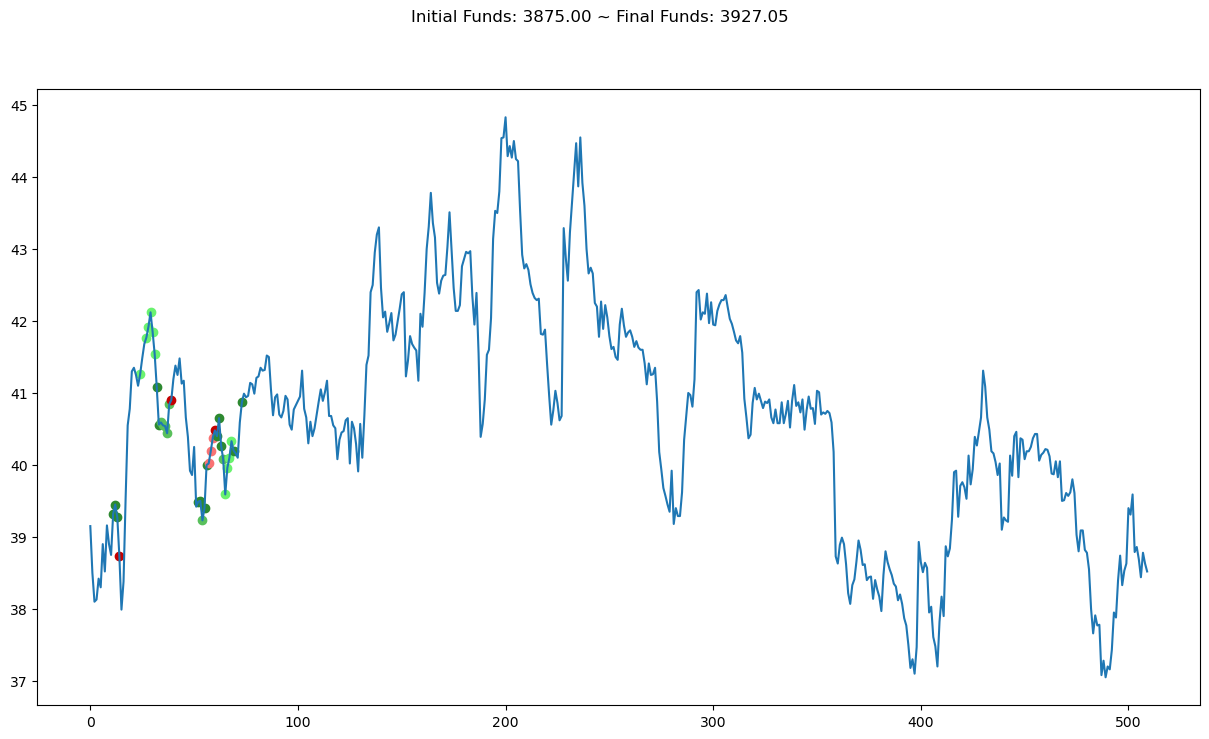

In [8]:
eval_py_env = TradingEnv(df=df, window_size=WINDOW_SIZE, frame_bound=(2000, 2500))
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

def render_policy_eval(policy, filename):
    time_step = eval_env.reset()
    while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
    eval_py_env.render('human')
    #plt.savefig(filename)

render_policy_eval(tf_agent.policy, "trained-agent")

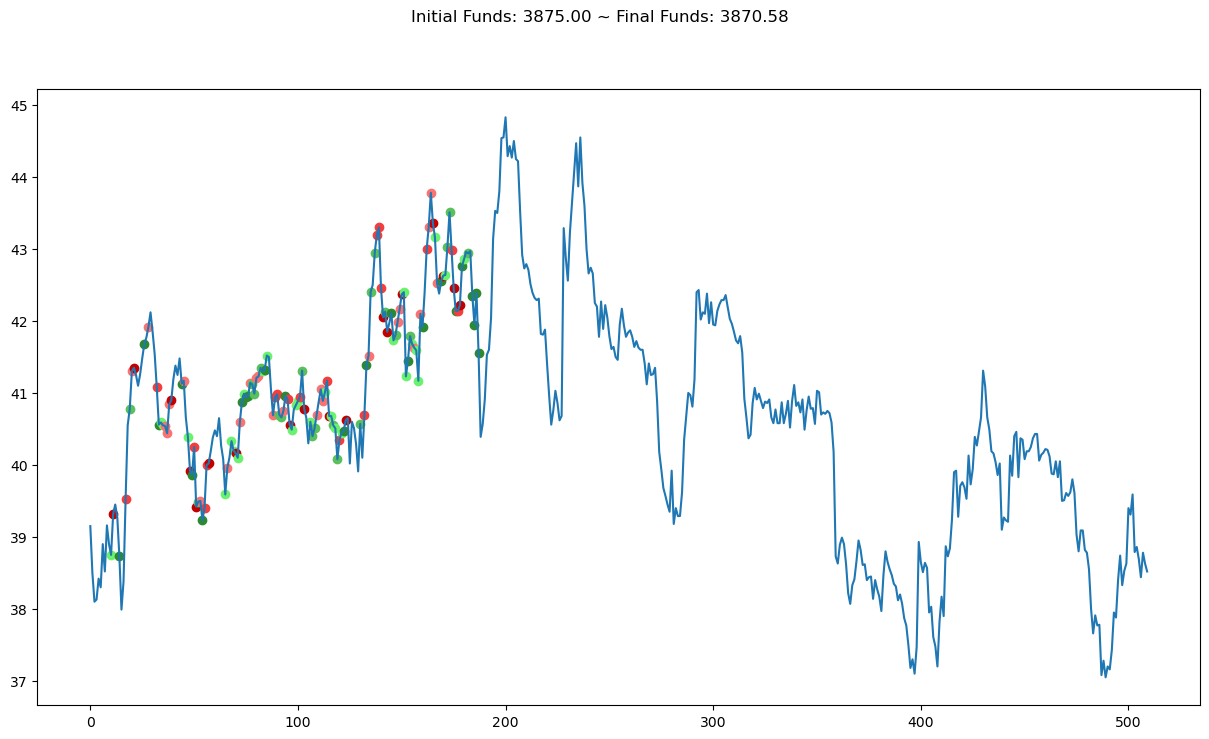

In [9]:
random_policy = random_tf_policy.RandomTFPolicy(eval_env.time_step_spec(),eval_env.action_spec())
render_policy_eval(random_policy, "random-agent")